# LSTM for Signal Forecasting
This example shows how to use a LSTM to predict the next value of a chirp signal using the previous SEQ_LENTH values.

New Code
- Preparing input data for LSTM into suitable format, including batching.
- Splitting into training and testing for time-series data.
- LSTM layer.
- LSTM training loop.
- Stateful vs Stateless.
- Visualizing the predictions made by the LSTM.

# Keras

Starting training loop...
Train on 3700 samples, validate on 1200 samples
Epoch 1/5
3700/3700 [==============================] - 3s 915us/step - loss: 0.0901 - val_loss: 0.0011
Epoch 2/5
3700/3700 [==============================] - 3s 854us/step - loss: 0.0229 - val_loss: 5.1766e-04
Epoch 3/5
3700/3700 [==============================] - 3s 852us/step - loss: 0.0119 - val_loss: 3.7238e-04
Epoch 4/5
3700/3700 [==============================] - 3s 855us/step - loss: 0.0065 - val_loss: 2.1517e-04
Epoch 5/5
3700/3700 [==============================] - 3s 856us/step - loss: 0.0032 - val_loss: 8.9801e-05


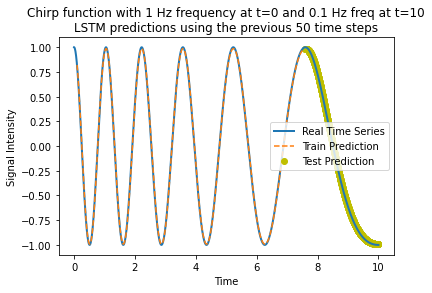

In [2]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
import random
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from scipy.signal import chirp
import matplotlib.pyplot as plt

# %% --------------------------------------- Set-Up --------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
PLOT_SIGNAL, PLOT_RESULT = False, True

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 1e-3
N_EPOCHS = 5
BATCH_SIZE = 20
DROPOUT = 0
SEQ_LEN = 50  # Number of previous time steps to use as inputs in order to predict the output at the next time step
HIDDEN_SIZE = 16  # If you want to use a linear layer after the LSTM, give this some value. If not, give None
STATEFUL = True  # Both of these hyperparameters
LOSS_WHOLE_SEQ = True  # are explained below

# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Generates a frequency-swept cosine signal (basically a cosine with changing frequency over time)
time_steps = np.linspace(0, 10, 5000)
x = chirp(time_steps, f0=1, f1=0.1, t1=10, method='linear')
if PLOT_SIGNAL:
    plt.plot(time_steps, x)
    plt.show()
# Splits into training and testing: we get the first 75% time steps as training and the rest as testing
x_train, x_test = x[:int(0.75*len(x))], x[int(0.75*len(x)):]
# Prepossesses the inputs on the required format (batch_size, timesteps, input_dim)
x_train_prep = np.empty((len(x_train)-SEQ_LEN, SEQ_LEN, 1))
if LOSS_WHOLE_SEQ:  # The targets are either the sequences shifted by one time step
    y_train_prep = np.empty((len(x_train)-SEQ_LEN, SEQ_LEN, 1))
else:  # or the single value of the signal at the time step that comes after the end of the input sequence
    y_train_prep = np.empty((len(x_train)-SEQ_LEN, 1))
for idx in range(len(x_train)-SEQ_LEN):
    x_train_prep[idx, :, :] = x_train[idx:SEQ_LEN+idx].reshape(-1, 1)
    if LOSS_WHOLE_SEQ:
        y_train_prep[idx, :] = x_train[idx+1:SEQ_LEN+idx+1].reshape(-1, 1)
    else:
        y_train_prep[idx, :] = x_train[SEQ_LEN+idx].reshape(1, 1)
x_test_prep = np.empty((len(x_test)-SEQ_LEN, SEQ_LEN, 1))
if LOSS_WHOLE_SEQ:
    y_test_prep = np.empty((len(x_test)-SEQ_LEN, SEQ_LEN, 1))
else:
    y_test_prep = np.empty((len(x_test) - SEQ_LEN, 1))
for idx in range(len(x_test)-SEQ_LEN):
    x_test_prep[idx, :, :] = x_test[idx:SEQ_LEN+idx].reshape(-1, 1)
    if LOSS_WHOLE_SEQ:
        y_test_prep[idx, :] = x_test[idx+1:SEQ_LEN+idx+1].reshape(-1, 1)
    else:
        y_test_prep[idx, :] = x_test[SEQ_LEN+idx].reshape(1, 1)
x_train, y_train, x_test, y_test = x_train_prep, y_train_prep, x_test_prep, y_test_prep
del x_train_prep, y_train_prep, x_test_prep, y_test_prep

# %% -------------------------------------- Training Prep ----------------------------------------------------------
if HIDDEN_SIZE is None:  # This layer takes an input of (batch_size, timesteps, input_dim).
    # In theory this should be enough (see PyTorch version) because the output function is a tanh and our signal is on
    # the interval [-1, 1]. Not sure why it's only learning half the signal...
    # Could it be due to some Keras internals regarding this function and the LSTM layer?
    model = Sequential([LSTM(units=1, dropout=DROPOUT, stateful=STATEFUL,
                             batch_input_shape=(BATCH_SIZE, SEQ_LEN, 1) if STATEFUL else None,
                             return_sequences=True if LOSS_WHOLE_SEQ else False)])
else:  # stateful=True means that it will take the hidden states of the previous batch as memory for the current batch
    # This is equivalent to passing the h_c_states as additional inputs in the PyTorch code.
    # Note that we need a constant batch_size in this case, but we cannot just drop the last batch as in PyTorch, so we
    # need to specify a batch_size such that both len(x_train) and len(x_test) are divisible by.
    model = Sequential([LSTM(units=HIDDEN_SIZE, dropout=DROPOUT, stateful=STATEFUL,
                             batch_input_shape=(BATCH_SIZE, SEQ_LEN, 1) if STATEFUL else None,
                             return_sequences=True if LOSS_WHOLE_SEQ else False),
                        Dense(1, activation="linear")])
    # return_sequences=True means that all the intermediate outputs of the LSTM will be returned, and thus the network
    # will be trained to take 1 previous time step as input and predict the next time step, but also to take 2
    # previous time steps as inputs and predict the next time step, and also 3, 4, ..., SEQ_LENGTH previous t_steps.
    # If False, only the last output will be returned. This means that the network will being trained specifically to
    # take SEQ_LENGTH previous time steps as inputs and predict the next time step.
model.compile(optimizer=Adam(lr=LR), loss="mean_squared_error")

# %% -------------------------------------- Training Loop ----------------------------------------------------------
print("Starting training loop...")
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_test, y_test))

# %% ------------------------------------------ Final Test -------------------------------------------------------------
if PLOT_RESULT:
    # Gets all of the predictions one last time.
    pred_train = model.predict(x_train, batch_size=BATCH_SIZE)  # batch_size again in case STATEFUL=True
    pred_test = model.predict(x_test, batch_size=BATCH_SIZE)
    # Stores only the last prediction using each sequence [:SEQ_LEN, 1:SEQ_LEN+1, ...] as inputs. This is the default
    # behaviour if LOSS_WHOLE_SEQ=False
    if LOSS_WHOLE_SEQ:
        predictions_train, predictions_test = [], []
        for idx in range(len(pred_train)):
            predictions_train.append(pred_train[idx, -1].reshape(-1))
        for idx in range(len(pred_test)):
            predictions_test.append(pred_test[idx, -1].reshape(-1))
        pred_train, pred_test = np.array(predictions_train), np.array(predictions_test)
    # Plots the actual signal and the predicted signal using the previous SEQ_LEN points of the signal for each pred
    plt.plot(time_steps, x, label="Real Time Series", linewidth=2)
    plt.plot(time_steps[SEQ_LEN:len(pred_train)+SEQ_LEN],
             pred_train, linestyle='dashed', label="Train Prediction")
    plt.scatter(time_steps[len(pred_train)+2*SEQ_LEN:],
                pred_test, color="y", label="Test Prediction")
    plt.title("Chirp function with 1 Hz frequency at t=0 and 0.1 Hz freq at t=10\n"
              "LSTM predictions using the previous {} time steps".format(SEQ_LEN))
    plt.xlabel("Time")
    plt.ylabel("Signal Intensity")
    plt.legend()
    plt.show()

# TensorFlow

Starting training loop...
Epoch 0 | Train Loss 0.04126 - Test Loss 0.00219
Epoch 1 | Train Loss 0.00314 - Test Loss 0.00115
Epoch 2 | Train Loss 0.00198 - Test Loss 0.00076
Epoch 3 | Train Loss 0.00140 - Test Loss 0.00102
Epoch 4 | Train Loss 0.00143 - Test Loss 0.00252


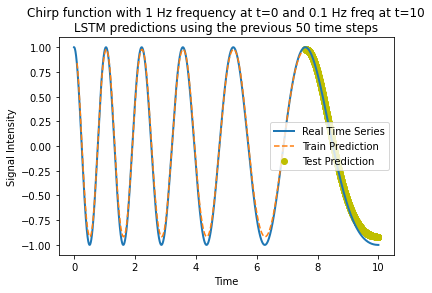

In [3]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import numpy as np
import tensorflow as tf
from scipy.signal import chirp
import matplotlib.pyplot as plt

# %% --------------------------------------- Set-Up --------------------------------------------------------------------
tf.random.set_seed(42)
np.random.seed(42)
PLOT_SIGNAL, PLOT_RESULT = False, True


# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 1e-3
N_EPOCHS = 5
BATCH_SIZE = 32
DROPOUT = 0
SEQ_LEN = 50  # Number of previous time steps to use as inputs in order to predict the output at the next time step
HIDDEN_SIZE = 16  # If you want to use a linear layer after the LSTM, give this some value. If not, give None
STATEFUL = False  # Both of these hyperparameters
LOSS_WHOLE_SEQ = False  # are explained below

# %% -------------------------------------- LSTM Class -----------------------------------------------------------------
class ChirpLSTM(tf.keras.Model):
    def __init__(self, dropout=DROPOUT):
        super(ChirpLSTM, self).__init__()
        # This layer takes an input of (batch_size, timesteps, input_dim).
        self.lstm = tf.keras.layers.LSTM(units=HIDDEN_SIZE if HIDDEN_SIZE is not None else 1, dropout=dropout,
                                         batch_input_shape=(BATCH_SIZE, SEQ_LEN, 1) if STATEFUL else (None, SEQ_LEN, 1),
                                         return_sequences=True if LOSS_WHOLE_SEQ else False, stateful=STATEFUL)
        # stateful=True means that it will take the hidden states of the previous batch as memory for the current batch
        # This is equivalent to passing the h_c_states as additional inputs in the PyTorch code.
        # return_sequences=True means that all the intermediate outputs of the LSTM will be returned, and thus the network
        # will be trained to take 1 previous time step as input and predict the next time step, but also to take 2
        # previous time steps as inputs and predict the next time step, and also 3, 4, ..., SEQ_LENGTH previous t_steps.
        # If False, only the last output will be returned. This means that the network will being trained specifically to
        # take SEQ_LENGTH previous time steps as inputs and predict the next time step.
        self.out = tf.keras.layers.Dense(1, activation="linear")
        self.training = True

    def call(self, x):
        lstm_out = self.lstm(x, training=self.training)
        if HIDDEN_SIZE:
            return self.out(lstm_out)
        else:  # In theory this should be enough (see PyTorch version) because the output function is a tanh and our
            # signal is on the interval [-1, 1]. Not sure why it's only learning half the signal...
            # Could it be due to some Keras internals regarding this function and the LSTM layer?
            return lstm_out

# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Generates a frequency-swept cosine signal (basically a cosine with changing frequency over time)
time_steps = np.linspace(0, 10, 5000)
x = chirp(time_steps, f0=1, f1=0.1, t1=10, method='linear')
if PLOT_SIGNAL:
    plt.plot(time_steps, x)
    plt.show()
# Splits into training and testing: we get the first 75% time steps as training and the rest as testing
x_train, x_test = x[:int(0.75*len(x))], x[int(0.75*len(x)):]
# Prepossesses the inputs on the required format (batch_size, timesteps, input_dim)
x_train_prep = np.empty((len(x_train)-SEQ_LEN, SEQ_LEN, 1))
for idx in range(len(x_train)-SEQ_LEN):
    x_train_prep[idx, :, :] = x_train[idx:SEQ_LEN+idx].reshape(-1, 1)
x_test_prep = np.empty((len(x_test)-SEQ_LEN, SEQ_LEN, 1))
for idx in range(len(x_test)-SEQ_LEN):
    x_test_prep[idx, :, :] = x_test[idx:SEQ_LEN+idx].reshape(-1, 1)
x_train, x_test = tf.cast(tf.convert_to_tensor(x_train_prep), tf.float32), tf.cast(tf.convert_to_tensor(x_test_prep), tf.float32)
del x_train_prep, x_test_prep

# %% -------------------------------------- Training Prep ----------------------------------------------------------
model = ChirpLSTM()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
criterion = tf.keras.losses.MeanSquaredError()

train_loss = tf.keras.metrics.Mean(name='train_loss')
@tf.function
def train(x, y, loss_whole_seq=LOSS_WHOLE_SEQ):
    model.training = True
    with tf.GradientTape() as tape:
        pred = model(x)
        if loss_whole_seq:
            loss = criterion(y, pred)
        else:
            loss = criterion(y[:, -1], pred[:, -1])
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

test_loss = tf.keras.metrics.Mean(name='test_loss')
@tf.function
def eval(x, y, loss_whole_seq=LOSS_WHOLE_SEQ):
    model.training = False
    pred = model(x)
    if loss_whole_seq:
        loss = criterion(y, pred)
    else:
        loss = criterion(y[:, -1], pred[:, -1])
    test_loss(loss)

# %% -------------------------------------- Training Loop ----------------------------------------------------------
print("Starting training loop...")
for epoch in range(N_EPOCHS):

    if STATEFUL:
        pass
        # This should also be possible and should be done, but there is some weird error
        # model.lstm.reset_states([tf.zeros((BATCH_SIZE, HIDDEN_SIZE)), tf.zeros((BATCH_SIZE, HIDDEN_SIZE))])
        # model.lstm.states = [tf.zeros((BATCH_SIZE, HIDDEN_SIZE)), tf.zeros((BATCH_SIZE, HIDDEN_SIZE))] does not work either
    for batch in range(len(x_train) // BATCH_SIZE):
        inp_inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)
        # The targets are either the sequences shifted by one time step
        tar_inds = slice(batch * BATCH_SIZE + 1, (batch + 1) * BATCH_SIZE + 1)
        # or the single value of the signal at the time step that comes after the end of the input sequence
        train(x_train[inp_inds], x_train[tar_inds])

    if STATEFUL:
        # This should be possible but apparently it is not...
        # model.lstm.reset_states([tf.zeros((len(x_test)-1, HIDDEN_SIZE)), tf.zeros((len(x_test)-1, HIDDEN_SIZE))])
        # eval(x_test[:-1], x_test[1:])

        # This should also be possible and should be done, but again apparently is not...
        # model.lstm.reset_states([tf.zeros((BATCH_SIZE, HIDDEN_SIZE)), tf.zeros((BATCH_SIZE, HIDDEN_SIZE))])
        for batch in range(len(x_test) // BATCH_SIZE):
            inp_inds = slice(batch * BATCH_SIZE, (batch + 1) * BATCH_SIZE)
            tar_inds = slice(batch * BATCH_SIZE + 1, (batch + 1) * BATCH_SIZE + 1)
            eval(x_test[inp_inds], x_test[tar_inds])
    else:
        eval(x_test[:-1], x_test[1:])

    print("Epoch {} | Train Loss {:.5f} - Test Loss {:.5f}".format(epoch, train_loss.result(), test_loss.result()))
    train_loss.reset_states(); test_loss.reset_states()

# %% ------------------------------------------ Final Test -------------------------------------------------------------
if PLOT_RESULT:
    model.training = False
    # Gets all of the predictions one last time.
    if STATEFUL:  # This ugly conditional could be avoided if the stateful stuff worked well on TF2... plus we are
        if LOSS_WHOLE_SEQ:  # missing the last batch and even using hidden states from training into testing...
            pred_train = np.empty((len(x_train)//BATCH_SIZE*BATCH_SIZE, SEQ_LEN, 1))  # See PyTorch or Keras versions
            pred_test = np.empty((len(x_test) // BATCH_SIZE * BATCH_SIZE, SEQ_LEN, 1))  # for ideal way of doing this
        else:
            pred_train = np.empty((len(x_train) // BATCH_SIZE * BATCH_SIZE, 1))
            pred_test = np.empty((len(x_test) // BATCH_SIZE * BATCH_SIZE, 1))
        for batch in range(len(x_train) // BATCH_SIZE):
            inp_inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)
            if LOSS_WHOLE_SEQ:
                pred_train[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE, :, :] = model(x_train[inp_inds])
            else:
                pred_train[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE, :] = model(x_train[inp_inds])
        for batch in range(len(x_test) // BATCH_SIZE):
            inp_inds = slice(batch * BATCH_SIZE, (batch + 1) * BATCH_SIZE)
            if LOSS_WHOLE_SEQ:
                pred_test[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE, :, :] = model(x_test[inp_inds])
            else:
                pred_test[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE, :] = model(x_test[inp_inds])
    else:
        pred_train = model(x_train).numpy()
        pred_test = model(x_test).numpy()
    # Stores only the last prediction using each sequence [:SEQ_LEN, 1:SEQ_LEN+1, ...] as inputs. This is the default
    # behaviour if LOSS_WHOLE_SEQ=False
    if LOSS_WHOLE_SEQ:
        predictions_train, predictions_test = [], []
        for idx in range(len(pred_train)):
            predictions_train.append(pred_train[idx, -1].reshape(-1))
        for idx in range(len(pred_test)):
            predictions_test.append(pred_test[idx, -1].reshape(-1))
        pred_train, pred_test = np.array(predictions_train), np.array(predictions_test)
    # Plots the actual signal and the predicted signal using the previous SEQ_LEN points of the signal for each pred
    plt.plot(time_steps, x, label="Real Time Series", linewidth=2)
    plt.plot(time_steps[SEQ_LEN:len(pred_train)+SEQ_LEN],
             pred_train, linestyle='dashed', label="Train Prediction")
    if STATEFUL:
        plt.scatter(time_steps[len(pred_train) + 2 * SEQ_LEN + BATCH_SIZE:-(
                len(x) - (len(pred_train) + 2 * SEQ_LEN + BATCH_SIZE) - len(pred_test))],
                    pred_test, color="y", label="Test Prediction")
    else:
        plt.scatter(time_steps[len(pred_train)+2*SEQ_LEN:],
                    pred_test, color="y", label="Test Prediction")
    plt.title("Chirp function with 1 Hz frequency at t=0 and 0.1 Hz freq at t=10\n"
              "LSTM predictions using the previous {} time steps".format(SEQ_LEN))
    plt.xlabel("Time"); plt.ylabel("Signal Intensity")
    plt.legend()
    plt.show()

# PyTorch

Starting training loop...
Epoch 0 | Train Loss 0.45213 - Test Loss 0.47828
Epoch 1 | Train Loss 0.36894 - Test Loss 0.41636
Epoch 2 | Train Loss 0.32535 - Test Loss 0.37837
Epoch 3 | Train Loss 0.29412 - Test Loss 0.34886
Epoch 4 | Train Loss 0.26875 - Test Loss 0.32443
Epoch 5 | Train Loss 0.24735 - Test Loss 0.30085
Epoch 6 | Train Loss 0.22559 - Test Loss 0.27120
Epoch 7 | Train Loss 0.19756 - Test Loss 0.22944
Epoch 8 | Train Loss 0.15883 - Test Loss 0.17316
Epoch 9 | Train Loss 0.11077 - Test Loss 0.11024
Epoch 10 | Train Loss 0.06444 - Test Loss 0.05902
Epoch 11 | Train Loss 0.03296 - Test Loss 0.03090
Epoch 12 | Train Loss 0.01804 - Test Loss 0.01939
Epoch 13 | Train Loss 0.01210 - Test Loss 0.01451
Epoch 14 | Train Loss 0.00938 - Test Loss 0.01194
Epoch 15 | Train Loss 0.00779 - Test Loss 0.01029
Epoch 16 | Train Loss 0.00669 - Test Loss 0.00910
Epoch 17 | Train Loss 0.00586 - Test Loss 0.00820
Epoch 18 | Train Loss 0.00521 - Test Loss 0.00747
Epoch 19 | Train Loss 0.00467 - Te

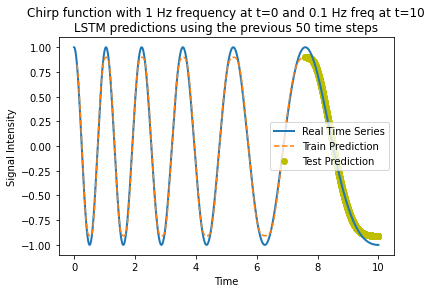

In [5]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
from scipy.signal import chirp
import matplotlib.pyplot as plt

# %% --------------------------------------- Set-Up --------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
PLOT_SIGNAL, PLOT_RESULT = False, True

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 1e-2
N_EPOCHS = 30
BATCH_SIZE = 128
DROPOUT = 0
SEQ_LEN = 50  # Number of previous time steps to use as inputs in order to predict the output at the next time step
HIDDEN_SIZE = 1  # If you want to use a linear layer after the LSTM, you can use a hidden size greater than 1
N_LAYERS = 1
STATEFUL = False  # Both of these hyperparameters
LOSS_WHOLE_SEQ = False  # are explained below


# %% -------------------------------------- LSTM Class -----------------------------------------------------------------
class ChirpLSTM(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, dropout=DROPOUT):
        super(ChirpLSTM, self).__init__()
        # The inputs to this layer are:
        # 1. The current input sequence, of shape (seq_len, batch, input_size)
        # 2. The last hidden state/s of the layer/s on the previous time step, of shape (n_layer, batch, hidden_size)
        # 3. The last cell state/s of the layer/s on the previous time step, of shape (n_layer, batch, hidden_size)
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout)
        # The outputs are:
        # 1. The hidden states of the last layer on the current time step, of shape (seq_len, batch, hidden_size)
        # 2. The last hidden state/s of the layer/s on the current time step, of shape (n_layer, batch, hidden_size)
        # 3. The last cell state/s of the layer/s on the current time step, of shape (n_layer, batch, hidden_size)
        # NOTE: Each hidden state is literally the output of the network at each time step
        # self.out = nn.Linear(hidden_size, 1)  # This linear layer would be needed if the signal we wanted to predict
        # was not on the range [-1, 1], as the output function of a LSTM is a tanh.

    def forward(self, p, hidden_state, cell_state):
        lstm_out, h_c_states = self.lstm(p, (hidden_state, cell_state))
        return lstm_out, h_c_states
        # return self.out(lstm_out), h_c_states


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Generates a frequency-swept cosine signal (basically a cosine with changing frequency over time)
time_steps = np.linspace(0, 10, 5000)
x = chirp(time_steps, f0=1, f1=0.1, t1=10, method='linear')
if PLOT_SIGNAL:
    plt.plot(time_steps, x)
    plt.show()
# Splits into training and testing: we get the first 75% time steps as training and the rest as testing
x_train, x_test = x[:int(0.75*len(x))], x[int(0.75*len(x)):]
# Prepossesses the inputs on the required format (seq_len, batch, input_size)
x_train_prep = np.empty((SEQ_LEN, len(x_train)-SEQ_LEN, 1))
for idx in range(len(x_train)-SEQ_LEN):
    x_train_prep[:, idx, :] = x_train[idx:SEQ_LEN+idx].reshape(-1, 1)
x_test_prep = np.empty((SEQ_LEN, len(x_test)-SEQ_LEN, 1))
for idx in range(len(x_test)-SEQ_LEN):
    x_test_prep[:, idx, :] = x_test[idx:SEQ_LEN+idx].reshape(-1, 1)
x_train, x_test = torch.Tensor(x_train_prep).to(device), torch.Tensor(x_test_prep).to(device)
x_train.requires_grad = True
del x_train_prep, x_test_prep

# %% -------------------------------------- Training Prep ----------------------------------------------------------
model = ChirpLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# %% -------------------------------------- Training Loop ----------------------------------------------------------
print("Starting training loop...")
for epoch in range(N_EPOCHS):

    h_state = torch.zeros(N_LAYERS, BATCH_SIZE, HIDDEN_SIZE).float().to(device)  # Initializes the hidden
    c_state = torch.zeros(N_LAYERS, BATCH_SIZE, HIDDEN_SIZE).float().to(device)  # and cell states
    loss_train = 0
    model.train()
    # Here we don't do x_train.shape[1]//BATCH_SIZE + 1 because each batch must have the same dim, due to the hidden
    for batch in range(x_train.shape[1]//BATCH_SIZE):  # and cell states. We could alternately pass a smaller h_c_state
        # to the last batch, initialized to zeros, same as in lines 80 and 81.
        inp_inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)  # The sequence starting on the next time step is
        tar_inds = slice(batch*BATCH_SIZE+1, (batch+1)*BATCH_SIZE+1)  # our target sequence
        optimizer.zero_grad()
        pred, h_c_state = model(x_train[:, inp_inds, :], h_state, c_state)
        if STATEFUL:
            # Detaches the last hidden and cell states from the graph before passing them to the next forward pass
            h_state, c_state = h_c_state[0].detach(), h_c_state[1].detach()
        else:  # STATEFUL means that it will take the hidden states of the previous batch
            pass  # as memory for the current batch. If not, we just pass the random states.
        if LOSS_WHOLE_SEQ:  # Computes the loss with all the hidden states and their corresponding targets, and not only
            loss = criterion(pred, x_train[:, tar_inds, :])  # the last hidden state. This means that the network is
        # being trained to take 1 previous time step as input and predict the next time step, but also to take 2
        # previous time steps as inputs and predict the next time step, and also 3, 4, ..., SEQ_LENGTH previous t_steps
        else:  # Uses only the last hidden state and its corresponding target to compute the loss. This means that the
            loss = criterion(pred[-1], x_train[-1, tar_inds, :])  # network is being trained specifically to take
        # SEQ_LENGTH previous time steps as input and predict the next time step
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

    h_state = torch.zeros(N_LAYERS, x_test.shape[1]-1, HIDDEN_SIZE).float().to(device)
    c_state = torch.zeros(N_LAYERS, x_test.shape[1]-1, HIDDEN_SIZE).float().to(device)
    model.eval()
    with torch.no_grad():
        pred, h_c_state = model(x_test[:, :-1, :], h_state, c_state)
        loss = criterion(pred, x_test[:, 1:, :])
        loss_test = loss.item()

    print("Epoch {} | Train Loss {:.5f} - Test Loss {:.5f}".format(epoch, loss_train/batch, loss_test))

# %% ------------------------------------------ Final Test -------------------------------------------------------------
if PLOT_RESULT:
    # Gets all of the predictions one last time
    with torch.no_grad():
        h_state = torch.zeros(N_LAYERS, x_train.shape[1], HIDDEN_SIZE).float().to(device)
        c_state = torch.zeros(N_LAYERS, x_train.shape[1], HIDDEN_SIZE).float().to(device)
        pred_train, _ = model(x_train, h_state, c_state)
        h_state = torch.zeros(N_LAYERS, x_test.shape[1], HIDDEN_SIZE).float().to(device)
        c_state = torch.zeros(N_LAYERS, x_test.shape[1], HIDDEN_SIZE).float().to(device)
        pred_test, _ = model(x_test, h_state, c_state)
    # Stores only the last prediction using each sequence [:SEQ_LEN, 1:SEQ_LEN+1, ...] as inputs
    predictions_train, predictions_test = [], []
    for idx in range(pred_train.shape[1]):
        predictions_train.append(pred_train[-1, idx].reshape(-1))
    for idx in range(pred_test.shape[1]):
        predictions_test.append(pred_test[-1, idx].reshape(-1))
    # Plots the actual signal and the predicted signal using the previous SEQ_LEN points of the signal for each pred
    plt.plot(time_steps, x, label="Real Time Series", linewidth=2)
    plt.plot(time_steps[SEQ_LEN:len(predictions_train)+SEQ_LEN],
             np.array(predictions_train), linestyle='dashed', label="Train Prediction")
    plt.scatter(time_steps[len(predictions_train)+2*SEQ_LEN:],
                np.array(predictions_test), color="y", label="Test Prediction")
    plt.title("Chirp function with 1 Hz frequency at t=0 and 0.1 Hz freq at t=10\n"
              "LSTM predictions using the previous {} time steps".format(SEQ_LEN))
    plt.xlabel("Time"); plt.ylabel("Signal Intensity")
    plt.legend()
    plt.show()